In [1]:
import pandas as pd
import random
import numpy as np
import os
import tensorflow.keras
from tensorflow import keras
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.optimizers import *
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Dense,GlobalAveragePooling2D
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet import preprocess_input as process_mobilenet
from tensorflow.keras.applications.inception_v3 import preprocess_input as process_inception
from tensorflow.keras.applications.resnet50 import preprocess_input as process_resnet
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input as process_vgg
import itertools

import cv2

from sklearn.metrics import confusion_matrix, accuracy_score
# Start CoLab
try:
  from google.colab import drive
  %tensorflow_version 2.x
  drive.mount('/content/drive', force_remount=True)
  COLAB = True
  print("Note: using Google CoLab")
except:
  print("Note: not using Google CoLab")
  COLAB = False

Mounted at /content/drive
Note: using Google CoLab


In [10]:
import tensorflow as tf
tf.test.gpu_device_name()

''

In [11]:
def wrap_generator(generator):
    
    while True:
        x,y = next(generator)
        y = tf.keras.utils.to_categorical(y)
        zeros = tf.zeros_like(y) + tf.constant([1.,0.])
        y = tf.concat([y,zeros], axis=0)
        yield x,y

In [12]:
def set_seed(seed):
    
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    random.seed(seed)



In [13]:
def get_model(train=True):
    set_seed(33)
    inp = Input((224,224,3))

    pre_1 = Lambda(process_mobilenet)

    mobilenet = MobileNet(weights = 'imagenet', include_top = False)

    for layer in mobilenet.layers[:-4]:
        layer.trainable = False

    mobilenet_process = pre_1(GaussianNoise(0.1)(inp))
    mobile_net = mobilenet(mobilenet_process)

    noise = Lambda(tf.zeros_like)(mobile_net)
    noise = GaussianNoise(0.1)(noise)

    if train:
        x = Lambda(lambda z: tf.concat(z, axis=0))([mobile_net,noise])
        x = Activation('relu')(x)
    else:
        x = mobile_net

    x_mobilenet = GlobalMaxPool2D()(x)
    x_mobilenet = Dense(1024, activation='relu')(x_mobilenet)
    a = x_mobilenet
    a = Dense(512, activation='relu')(a)
    a = Dense(128, activation='relu')(a)
    out = Dense(2, activation='softmax')(a)
 
    model = Model(inp, out)
    model.compile(Adam(lr=1e-3), loss='binary_crossentropy')
    
    return model

In [14]:

### CREATE EMPTY GENERATORS ###

train_datagen = ImageDataGenerator()
test_datagen = ImageDataGenerator()

SHAPE = (224,224,3)

In [15]:
### FLOW GENERATORS ###

train_generator = train_datagen.flow_from_directory(
            '/content/drive/My Drive/Dataset_Project/Dataset 4',
            target_size = (SHAPE[0], SHAPE[1]),
            batch_size = 256,
            class_mode = 'categorical',
            shuffle = True,
            seed = 33,
            classes = ['no']
    )

test_generator = test_datagen.flow_from_directory(
            '/content/drive/My Drive/Dataset_Project/Dataset 2/',
            target_size = (SHAPE[0], SHAPE[1]),
            batch_size = 256,
            class_mode = 'categorical',
            shuffle = False,
            seed = 33,
            classes = ['no','yes']
)

Found 1500 images belonging to 1 classes.
Found 253 images belonging to 2 classes.


In [16]:
print(train_generator.class_indices)
print(test_generator.class_indices)

{'no': 0}
{'no': 0, 'yes': 1}


In [18]:


model = get_model()
model.fit(wrap_generator(train_generator), steps_per_epoch=train_generator.samples/train_generator.batch_size, epochs=5)

Epoch 1/5
5/5 [==============================] - 239s 46s/step - loss: 1.0354
Epoch 2/5
5/5 [==============================] - 68s 12s/step - loss: 0.8582
Epoch 3/5
5/5 [==============================] - 68s 12s/step - loss: 0.9814
Epoch 4/5
5/5 [==============================] - 68s 12s/step - loss: 0.7937
Epoch 5/5
5/5 [==============================] - 68s 12s/step - loss: 0.9660


In [19]:
  ### RETRIVE TEST LABEL FROM GENERATOR ###

test_num = test_generator.samples

label_test = []
for i in range((test_num // test_generator.batch_size)+1):
    X,y = test_generator.next()
    label_test.append(y)
        
label_test = np.argmax(np.vstack(label_test), axis=1)
label_test.shape
print(label_test)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


In [20]:
### SWITCH TO INFERENCE MODE TO COMPUTE PREDICTIONS ###

ineference_model = get_model(train=False)

In [21]:
### COMPUTE PREDICTIONS ON TEST DATA ###

pred_test = np.argmax(ineference_model.predict(test_generator), axis=1)
print(pred_test)

[0 0 0 1 0 1 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 1 0 1 1 0 0
 0 0 0 1 0 0 0 1 1 0 0 0 0 0 0 0 0 1 0 1 1 0 1 0 0 0 0 1 0 0 0 1 0 0 0 0 0
 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0
 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 1 0 0 0 0 0 0
 0 1 0 0 1 0 0 0 1 0 1 0 0 0 0 1 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 1 0 1 1 0 0 1 1 0 0 0 0 0 1 0 0 1 0 1 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0
 0 0 0 1 0 0 0 0 1 0 1 0 1 1 0 0 0 0 0 0 1 1 1 0 1 0 0 1 0 1 0]


In [22]:

### ACCURACY ON TEST DATA ###

print('ACCURACY:', accuracy_score(label_test, pred_test))

ACCURACY: 0.44664031620553357


In [23]:
def plot_confusion_matrix(cm, classes, title='Confusion matrix', cmap=plt.cm.Blues):

    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=25)
    # plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90, fontsize=15)
    plt.yticks(tick_marks, classes, fontsize=15)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black", fontsize = 14)

    plt.ylabel('True label', fontsize=20)
    plt.xlabel('Predicted label', fontsize=20)

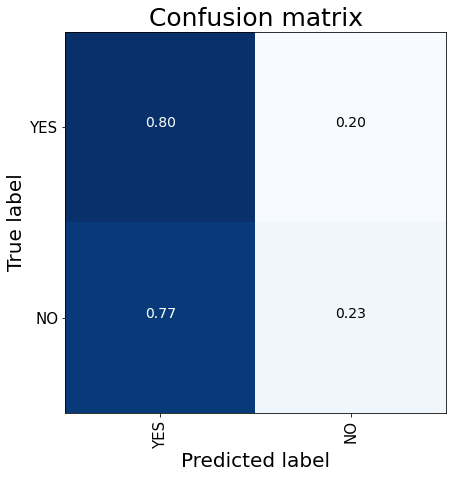

In [24]:
### CONFUSION MATRIX ON TEST DATA ###

cnf_matrix = confusion_matrix(label_test, pred_test)

plt.figure(figsize=(7,7))
plot_confusion_matrix(cnf_matrix, classes=['YES','NO'])
plt.show()

In [25]:
from sklearn .metrics import roc_auc_score 
from sklearn import metrics
print(roc_auc_score(label_test,pred_test))

0.510862409479921


In [26]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
gaussian_noise_4 (GaussianNoise (None, 224, 224, 3)  0           input_5[0][0]                    
__________________________________________________________________________________________________
lambda_6 (Lambda)               (None, 224, 224, 3)  0           gaussian_noise_4[0][0]           
__________________________________________________________________________________________________
mobilenet_1.00_224 (Functional) (None, None, None, 1 3228864     lambda_6[0][0]                   
____________________________________________________________________________________________

In [ ]:

%matplotlib inline

def classify_array(images,classes):
    inv_map = {v: k for k, v in classes.items()}
    
    for url in images:
        x = []
        ImageFile.LOAD_TRUNCATED_IMAGES = False
        response = requests.get(url)
        img = Image.open(BytesIO(response.content))
        img.load()
        img = img.resize((IMAGE_WIDTH,IMAGE_HEIGHT),Image.ANTIALIAS)

        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = preprocess_input(x)
        x = x[:,:,:,:3]
        
        
        pred = model.predict(x)

        display(L)
        display(img)
        pred2 = int(np.argmax(pred,axis=1))
        print(pred)
        print(inv_map[pred2])